# STATS 607
## Problem set 1

Each of the problems below can be solved using Numpy, potentially in combination with some other libraries as indicated. It is not necessary to write any `for` loops -- try to eliminate them from your code!

In [1]:
import numpy as np

#### 1: Influence


An influence function measures how sensitive an estimate is to the presence or absence of a particular sample. For example, if $\hat{\beta}_{-i}$ is the regression coefficient when the $i$-th sample is dropped, then $\| \hat{\beta} - \hat{\beta}_{-i}\|$ measures the influence of that sample on $\hat\beta$.

From regression textbooks we know that $$\hat\beta - \hat{\beta}_{-i}
= \frac{(\mathbf{X}^{\top}\mathbf{X})^{-1}{X}_i\hat{e}_i}{1-h_{ii}},$$
where $h_{ii}$ is the $i$th diagonal entry of the hat matrix, but suppose you forgot this fact.

Use Numpy to brute-force
the computation by running $n$ separate regressions. As always, avoid using for loops
except where absolutely necessary. 

**Hint**: from `X` create an array `X_minus_i` with `X_minus_i.shape = (n, n - 1, p)`, such that `X_minus_i[i]` is `X` with the $i$th row removed. Then perform $n$ least squares fits by batching over the leading dimension.

In [76]:
# random data
n = 500
p = 51
X = np.random.normal(0,1,(n,p))

In [77]:

# using np.vectorize to apply least squares to each row of X

#  array shaping
X_tile = np.tile(X,(n,1,1))
W = np.ones((n,n))
W = W - np.eye(n)
W = W.astype(bool)
X_minus_i = X_tile[W].reshape(n,n-1,p)

# least squares definition
def least_squares(U):
    Y = U[:,0]
    V = U[:,1:]
    Vt = V.T
    return np.linalg.inv(Vt @ V) @ Vt @ Y
vectorized_least_squares = np.vectorize(least_squares, signature='(n,p)->(q)')

# model fitting
Beta_i = vectorized_least_squares(X_minus_i)
Beta_i[0][:5]

array([-0.06049282,  0.08275335, -0.00026133,  0.05656137, -0.00719575])

In [84]:
# one for loop over the least squares fit

# array shaping
Y = X[:,0][:,None]
XY = X[:,1:]
Y_tile = np.tile(Y,(n,1,1))
XY_tile = np.tile(XY,(n,1,1))
XY_minus_i = XY_tile[W].reshape(n,n-1,p-1)
Y_minus_i = Y_tile[W].reshape(n,n-1,1)

# least squares definition
def least_squares_v2(U,V):
    Vt = V.T
    return np.linalg.inv(Vt @ V) @ Vt @ U

# model fitting
Beta_i_v2 = np.array([least_squares_v2(Y_minus_i[i],XY_minus_i[i]) 
                      for i in range(n)]) # one for loop
Beta_i_v2 = Beta_i_v2.reshape(500,50)
Beta_i_v2[0][:5]


array([-0.06049282,  0.08275335, -0.00026133,  0.05656137, -0.00719575])

In [74]:
# verifying results with known influence function
i = 0
Beta = least_squares(X)
inv_XX = np.linalg.inv(XY.T @ XY)
Hat = XY @ inv_XX @ XY.T
Hat_diag = np.diag(Hat)
e = Y - XY @ Beta
e_i = e[i]
infl_formula = inv_XX @ XY[i] * e_i[0] / (1 - Hat_diag[i])
infl_formula[:3], (Beta - Beta_i[i])[:3]

(array([-1.55877130e-04, -4.21087696e-04,  4.50907705e-05]),
 array([-1.55877130e-04, -4.21087696e-04,  4.50907705e-05]))

#### 2. Image segmentation

Write a simple image segmentation algorithm that clusters adjacent pixels based on some sort of distance metric.  (Two pixels are considered to be adjacent if they share an edge or a corner. Thus, an "interior" pixel has eight neighbors as in this diagram:

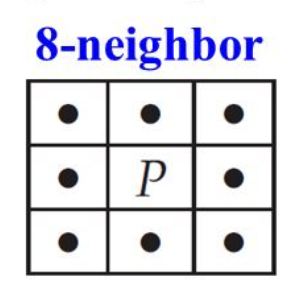

Test your algorithm out on the following image:

In [7]:
# pip install scikit-image

import matplotlib.pyplot as plt
from skimage import data

image = data.astronaut()
plt.imshow(image)

ModuleNotFoundError: No module named 'skimage'

For example, using Euclidean distance and a cutoff of $\|x - y \| < 0.05$ for cluster membership, I obtained the following result:

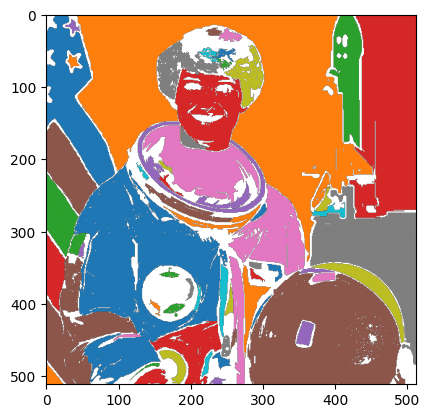

**Hints**:

- Color images are represented as 3d `int8` arrays of shape $(H, W, 3)$, where $H$ and $W$ are the height and width, and the trailing axis contains the intensity of the red, green, and blue channels. Pixel intensities range from 0 to 255, but it is conventional to normalize them to $[0,1]$ to compute distances.
- Naively computing the pairwise distance between all $512 \times 512$ pixels would produce an 192GiB array, too big to fit in your computer's memory. You'll have to find a more clever way that conserves memory.
- One way of tackling this problem is to construct a graph where adjacent pixels are connected by an edge if they are similar, and considering the connected components of this graph. The [`networkx.connected_components()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html) function is useful here.

#### 3. ECDF  

Given a set of univariate observations $x_1,\dots,x_n$, the empirical distribution function $\hat{F}_n(x): \mathbb{R} \to [0, 1]$ returns the fraction of the observations that are less than or equal to $x$. 

Write a function `ecdf(x)` which takes a data vector `x` and returns a _function_ `F` which, when evaluated, returns the ECDF. Use this function to make a plot of the ECDF for the following data:

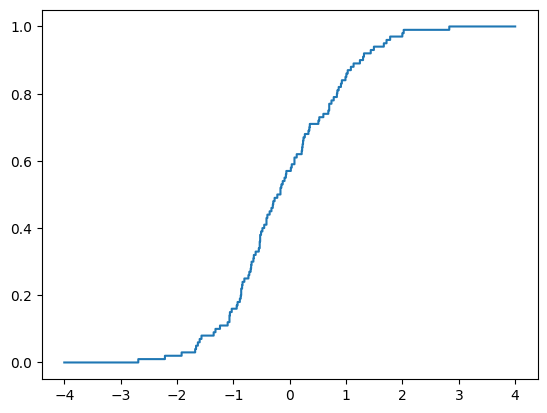

In [193]:
import matplotlib.pyplot as plt

x = rng.normal(size=100)
F = ecdf(x)
y = np.linspace(-4, 4, 1000)
plt.plot(y, F(y), drawstyle='steps-post')

#### 4. Brownian bridge

A well-known fact from empirical process theory is that the random function 

$$B_n(t) = \sqrt(n)[\hat{F}_n(t) - F(t)]$$

converges weakly to a [Brownian bridge](https://en.wikipedia.org/wiki/Brownian_bridge). This means in particular that 

$$W_n(t) := B_n(t) + t Z,$$ 

where $Z$ is standard normal independent of $B_n$, is approximately a Wiener process (standard Brownian motion) for large $n$.

Convince yourself (and me) of this fact by simulating a large amount of data and studying the finite-dimensional marginal distributions of $W_n(t)$.

**Hints**:
- A Weiner process is characterized by: $W(0)=0$ a.s.; independent Gaussian increments, and almost sure continuity. These imply that $\mathbb{E}W(t)=0$ and $\mathrm{cov}(W(s),W(t))=s \wedge t$ for all $s$ and $t$.
- By implementing `ecdf()` appropriately in the preceding exercise, you should be able to easily perform bootstrap simulations for any statistics you want by introducing a batch dimension to your data.

#### 5. Matrix patterns

In the table below, entries highlighted in <span style="color:red">red</span> form a $5\times 5$ cross. If you add up the highlighted entries you get $92 + 31 + 18 + 77 + 56 + 15 + 53 + 18 + 30 + 18= 408.$

In [3]:
# (code to generate matrix)
rng = np.random.default_rng(98765)
A = np.random.randint(1, 100, size=(30, 30))

   What's the largest sum you can make using a $5 \times 5$ cross in this table? (Consider only complete crosses; ones that are cut off by edge effects don't count.)

<table><tbody><tr><td>24</td><td>83</td><td>16</td><td>45</td><td>13</td><td>83</td><td>25</td><td>7</td><td>60</td><td>56</td><td>7</td><td>99</td><td>15</td><td>54</td><td>78</td><td>67</td><td>96</td><td>35</td><td>84</td><td>5</td><td>40</td><td>26</td><td>45</td><td>30</td><td>51</td><td>23</td><td>29</td><td>58</td><td>88</td><td>59</td></tr><tr><td>57</td><td>23</td><td>90</td><td>28</td><td>87</td><td>19</td><td>71</td><td>79</td><td>27</td><td>16</td><td>35</td><td>75</td><td>74</td><td>17</td><td>3</td><td>98</td><td>5</td><td>74</td><td>98</td><td>1</td><td>24</td><td>91</td><td>36</td><td>67</td><td>48</td><td>16</td><td>70</td><td>65</td><td>42</td><td>92</td></tr><tr><td>26</td><td>28</td><td>29</td><td>55</td><td>33</td><td>68</td><td>46</td><td>59</td><td>15</td><td>3</td><td>46</td><td>91</td><td>72</td><td>17</td><td>43</td><td>38</td><td>75</td><td>65</td><td>44</td><td>29</td><td>10</td><td>44</td><td>25</td><td>50</td><td>87</td><td>86</td><td>52</td><td>56</td><td>99</td><td>24</td></tr><tr><td>51</td><td>71</td><td>57</td><td>20</td><td>76</td><td>30</td><td>29</td><td>17</td><td>81</td><td>12</td><td>47</td><td>92</td><td>81</td><td>75</td><td>98</td><td>97</td><td>63</td><td>42</td><td>66</td><td>92</td><td>37</td><td>21</td><td>54</td><td>28</td><td>47</td><td>5</td><td>32</td><td>11</td><td>75</td><td>1</td></tr><tr><td>27</td><td>6</td><td>32</td><td>70</td><td>9</td><td>60</td><td>59</td><td>19</td><td>5</td><td>79</td><td>88</td><td>41</td><td>36</td><td>75</td><td>93</td><td>27</td><td>39</td><td>88</td><td>4</td><td>73</td><td>65</td><td>7</td><td>99</td><td>28</td><td>57</td><td>69</td><td>8</td><td>44</td><td>11</td><td>18</td></tr><tr><td>79</td><td>31</td><td>74</td><td>37</td><td>27</td><td>69</td><td>48</td><td>96</td><td>17</td><td>1</td><td><span style='color:red'>92</span></td><td>5</td><td>43</td><td>75</td><td>65</td><td>98</td><td>40</td><td>15</td><td>19</td><td>31</td><td>33</td><td>39</td><td>16</td><td>86</td><td>34</td><td>86</td><td>34</td><td>86</td><td>30</td><td>41</td></tr><tr><td>98</td><td>88</td><td>45</td><td>96</td><td>36</td><td>54</td><td>54</td><td>68</td><td>50</td><td>87</td><td><span style='color:red'>31</span></td><td>31</td><td>67</td><td>63</td><td>42</td><td>57</td><td>34</td><td>2</td><td>40</td><td>94</td><td>79</td><td>56</td><td>9</td><td>30</td><td>91</td><td>72</td><td>60</td><td>8</td><td>42</td><td>43</td></tr><tr><td>66</td><td>10</td><td>39</td><td>86</td><td>46</td><td>29</td><td>48</td><td>37</td><td><span style='color:red'>15</span></td><td><span style='color:red'>53</span></td><td><span style='color:red'>18</span></td><td><span style='color:red'>30</span></td><td><span style='color:red'>18</span></td><td>36</td><td>35</td><td>62</td><td>3</td><td>65</td><td>44</td><td>45</td><td>60</td><td>99</td><td>96</td><td>50</td><td>84</td><td>98</td><td>15</td><td>99</td><td>58</td><td>23</td></tr><tr><td>43</td><td>83</td><td>94</td><td>33</td><td>25</td><td>65</td><td>61</td><td>11</td><td>11</td><td>47</td><td><span style='color:red'>77</span></td><td>43</td><td>75</td><td>91</td><td>4</td><td>64</td><td>49</td><td>50</td><td>39</td><td>21</td><td>37</td><td>42</td><td>90</td><td>39</td><td>22</td><td>93</td><td>68</td><td>1</td><td>65</td><td>55</td></tr><tr><td>10</td><td>46</td><td>32</td><td>75</td><td>9</td><td>14</td><td>61</td><td>11</td><td>79</td><td>16</td><td><span style='color:red'>56</span></td><td>12</td><td>92</td><td>97</td><td>96</td><td>36</td><td>32</td><td>55</td><td>32</td><td>11</td><td>79</td><td>97</td><td>20</td><td>58</td><td>35</td><td>81</td><td>92</td><td>69</td><td>12</td><td>53</td></tr><tr><td>99</td><td>73</td><td>72</td><td>86</td><td>85</td><td>51</td><td>81</td><td>26</td><td>41</td><td>37</td><td>99</td><td>64</td><td>33</td><td>12</td><td>89</td><td>36</td><td>24</td><td>93</td><td>80</td><td>79</td><td>92</td><td>83</td><td>46</td><td>60</td><td>89</td><td>63</td><td>21</td><td>74</td><td>37</td><td>96</td></tr><tr><td>1</td><td>70</td><td>23</td><td>10</td><td>40</td><td>43</td><td>13</td><td>46</td><td>85</td><td>26</td><td>90</td><td>44</td><td>69</td><td>81</td><td>44</td><td>9</td><td>37</td><td>36</td><td>39</td><td>89</td><td>42</td><td>22</td><td>66</td><td>31</td><td>24</td><td>75</td><td>59</td><td>38</td><td>11</td><td>76</td></tr><tr><td>24</td><td>93</td><td>38</td><td>7</td><td>7</td><td>3</td><td>66</td><td>85</td><td>32</td><td>85</td><td>84</td><td>37</td><td>44</td><td>73</td><td>23</td><td>4</td><td>24</td><td>53</td><td>60</td><td>24</td><td>76</td><td>4</td><td>36</td><td>40</td><td>96</td><td>10</td><td>65</td><td>55</td><td>79</td><td>67</td></tr><tr><td>86</td><td>9</td><td>16</td><td>19</td><td>17</td><td>87</td><td>67</td><td>8</td><td>59</td><td>26</td><td>60</td><td>51</td><td>93</td><td>83</td><td>67</td><td>55</td><td>8</td><td>77</td><td>29</td><td>2</td><td>19</td><td>57</td><td>21</td><td>31</td><td>78</td><td>40</td><td>69</td><td>41</td><td>46</td><td>81</td></tr><tr><td>73</td><td>32</td><td>24</td><td>11</td><td>76</td><td>67</td><td>71</td><td>61</td><td>41</td><td>12</td><td>56</td><td>70</td><td>76</td><td>69</td><td>86</td><td>30</td><td>13</td><td>4</td><td>37</td><td>77</td><td>61</td><td>77</td><td>72</td><td>70</td><td>52</td><td>64</td><td>70</td><td>64</td><td>12</td><td>53</td></tr><tr><td>81</td><td>62</td><td>42</td><td>70</td><td>87</td><td>49</td><td>67</td><td>53</td><td>22</td><td>37</td><td>10</td><td>33</td><td>41</td><td>24</td><td>12</td><td>36</td><td>56</td><td>18</td><td>30</td><td>11</td><td>20</td><td>81</td><td>7</td><td>20</td><td>92</td><td>20</td><td>79</td><td>22</td><td>35</td><td>14</td></tr><tr><td>55</td><td>49</td><td>11</td><td>70</td><td>1</td><td>29</td><td>92</td><td>39</td><td>30</td><td>44</td><td>33</td><td>36</td><td>32</td><td>84</td><td>38</td><td>97</td><td>77</td><td>30</td><td>13</td><td>93</td><td>63</td><td>89</td><td>72</td><td>23</td><td>73</td><td>1</td><td>61</td><td>94</td><td>52</td><td>61</td></tr><tr><td>65</td><td>86</td><td>65</td><td>86</td><td>80</td><td>18</td><td>65</td><td>50</td><td>37</td><td>39</td><td>5</td><td>44</td><td>43</td><td>90</td><td>51</td><td>98</td><td>19</td><td>21</td><td>41</td><td>71</td><td>51</td><td>16</td><td>55</td><td>67</td><td>47</td><td>28</td><td>61</td><td>64</td><td>69</td><td>42</td></tr><tr><td>61</td><td>99</td><td>28</td><td>85</td><td>57</td><td>53</td><td>77</td><td>95</td><td>34</td><td>11</td><td>5</td><td>1</td><td>99</td><td>89</td><td>32</td><td>23</td><td>65</td><td>16</td><td>23</td><td>80</td><td>80</td><td>67</td><td>85</td><td>60</td><td>97</td><td>2</td><td>70</td><td>11</td><td>92</td><td>93</td></tr><tr><td>70</td><td>19</td><td>76</td><td>51</td><td>64</td><td>54</td><td>28</td><td>58</td><td>37</td><td>81</td><td>90</td><td>11</td><td>73</td><td>38</td><td>34</td><td>68</td><td>19</td><td>98</td><td>80</td><td>60</td><td>87</td><td>28</td><td>63</td><td>51</td><td>4</td><td>64</td><td>75</td><td>56</td><td>32</td><td>64</td></tr><tr><td>31</td><td>94</td><td>89</td><td>89</td><td>49</td><td>85</td><td>62</td><td>1</td><td>97</td><td>67</td><td>52</td><td>72</td><td>50</td><td>95</td><td>42</td><td>20</td><td>73</td><td>57</td><td>16</td><td>29</td><td>42</td><td>1</td><td>28</td><td>59</td><td>39</td><td>66</td><td>2</td><td>14</td><td>75</td><td>66</td></tr><tr><td>98</td><td>59</td><td>80</td><td>31</td><td>84</td><td>43</td><td>78</td><td>41</td><td>99</td><td>60</td><td>47</td><td>73</td><td>85</td><td>92</td><td>52</td><td>20</td><td>23</td><td>43</td><td>21</td><td>95</td><td>17</td><td>3</td><td>63</td><td>15</td><td>60</td><td>93</td><td>24</td><td>4</td><td>43</td><td>71</td></tr><tr><td>21</td><td>43</td><td>60</td><td>21</td><td>65</td><td>90</td><td>39</td><td>14</td><td>68</td><td>8</td><td>4</td><td>18</td><td>35</td><td>84</td><td>93</td><td>15</td><td>54</td><td>75</td><td>69</td><td>28</td><td>9</td><td>15</td><td>65</td><td>97</td><td>30</td><td>2</td><td>22</td><td>54</td><td>47</td><td>2</td></tr><tr><td>63</td><td>69</td><td>12</td><td>47</td><td>21</td><td>12</td><td>44</td><td>13</td><td>2</td><td>39</td><td>45</td><td>75</td><td>98</td><td>46</td><td>85</td><td>34</td><td>73</td><td>37</td><td>73</td><td>8</td><td>10</td><td>1</td><td>27</td><td>74</td><td>72</td><td>94</td><td>71</td><td>38</td><td>60</td><td>34</td></tr><tr><td>42</td><td>81</td><td>71</td><td>17</td><td>78</td><td>42</td><td>95</td><td>36</td><td>50</td><td>59</td><td>18</td><td>66</td><td>20</td><td>39</td><td>95</td><td>38</td><td>49</td><td>72</td><td>65</td><td>45</td><td>36</td><td>45</td><td>99</td><td>50</td><td>61</td><td>67</td><td>87</td><td>21</td><td>21</td><td>69</td></tr><tr><td>28</td><td>50</td><td>65</td><td>13</td><td>80</td><td>51</td><td>29</td><td>29</td><td>53</td><td>90</td><td>69</td><td>68</td><td>97</td><td>95</td><td>56</td><td>4</td><td>84</td><td>97</td><td>29</td><td>80</td><td>76</td><td>8</td><td>35</td><td>76</td><td>37</td><td>57</td><td>17</td><td>5</td><td>25</td><td>14</td></tr><tr><td>9</td><td>35</td><td>61</td><td>47</td><td>46</td><td>20</td><td>41</td><td>14</td><td>47</td><td>56</td><td>22</td><td>51</td><td>26</td><td>79</td><td>93</td><td>99</td><td>26</td><td>23</td><td>72</td><td>56</td><td>96</td><td>87</td><td>15</td><td>51</td><td>25</td><td>66</td><td>49</td><td>23</td><td>99</td><td>98</td></tr><tr><td>27</td><td>68</td><td>56</td><td>69</td><td>93</td><td>46</td><td>92</td><td>87</td><td>32</td><td>55</td><td>89</td><td>7</td><td>56</td><td>99</td><td>39</td><td>38</td><td>17</td><td>65</td><td>12</td><td>83</td><td>87</td><td>18</td><td>82</td><td>73</td><td>2</td><td>71</td><td>41</td><td>42</td><td>46</td><td>25</td></tr><tr><td>21</td><td>97</td><td>46</td><td>13</td><td>77</td><td>36</td><td>82</td><td>30</td><td>97</td><td>14</td><td>93</td><td>23</td><td>48</td><td>77</td><td>88</td><td>88</td><td>49</td><td>3</td><td>32</td><td>86</td><td>2</td><td>44</td><td>21</td><td>71</td><td>50</td><td>73</td><td>94</td><td>53</td><td>28</td><td>59</td></tr><tr><td>32</td><td>56</td><td>37</td><td>80</td><td>90</td><td>74</td><td>10</td><td>60</td><td>51</td><td>85</td><td>58</td><td>33</td><td>29</td><td>77</td><td>34</td><td>67</td><td>38</td><td>23</td><td>59</td><td>66</td><td>61</td><td>72</td><td>81</td><td>16</td><td>95</td><td>99</td><td>79</td><td>7</td><td>55</td><td>65</td></tr></tbody></table>